# Examine the new query

In [28]:
%matplotlib notebook

In [52]:
# imports
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.cosmology import Planck15 as cosmo

sys.path.append(os.path.abspath("./py"))
import tpe_sample as tsmpl
import tpe_stack as tstack

## Load

In [2]:
qso_fg = Table.read('QPQ_v2000_R15_novette.fits',hdu=1)
qso_bg = Table.read('QPQ_v2000_R15_novette.fits',hdu=2)

In [3]:
qso_fg['LOGLV'][0:5]

30.7522770417
30.7522770417
30.7522770417
30.018314518
30.018314518


## TPE

In [4]:
reload(tsmpl)
tpe = tsmpl.make_tpe(31.2, qso_fg=qso_fg, qso_bg=qso_bg)

10263 pairs satisfy the Lcut of 31.2
Database is igmspec
Created on 2017-Jan-05
Database is QPQ
Created on 2017-Jan-02
Your search yielded 6697 matches from 10263 input coordinates
Your search yielded 197 matches from 10263 input coordinates
Your search yielded 4781 matches from 10263 input coordinates
Your search yielded 88 matches from 10263 input coordinates
4799 f/g quasars in IgmSpec or QPQspec
6713 b/g quasars in IgmSpec or QPQspec
3909 quasar pairs where both has a spec)
Generating TPE table from those with a good b/g spec


In [5]:
tpe[0:3]

FG_Z,FG_LOGLV,FG_RA,FG_DEC,FG_IGM_ID,FG_QPQ_ID,FG_MYERS_ZEM_SOURCE,BG_Z,BG_RA,BG_DEC,BG_IGM_ID,BG_QPQ_ID
float64,float64,float64,float64,int64,int64,str8,float64,float64,float64,int64,int64
2.97816991806,31.4488724116,240.26607,34.173636,251906,-1,SDSS-HW,3.007999897,240.39841,34.243126,252052,-1
2.8995680809,31.3432069543,239.84722,33.647755,251429,-1,SDSS-HW,3.0616850853,239.99184,33.618753,251567,-1
1.86253488064,38.3132521513,239.46599,34.879942,-1,-1,,1.94299995899,239.54349,34.882073,251046,-1


## Deal with Junk

In [6]:
c_fg = SkyCoord(ra=tpe['FG_RA'], dec=tpe['FG_DEC'], unit='deg')
c_bg = SkyCoord(ra=tpe['BG_RA'], dec=tpe['BG_DEC'], unit='deg')

In [7]:
sep = c_fg.separation(c_bg)

In [8]:
close = sep < 5*u.arcsec   # There are several ok ones at 7"
np.sum(close)

18

In [9]:
tpe[close]

FG_Z,FG_LOGLV,FG_RA,FG_DEC,FG_IGM_ID,FG_QPQ_ID,FG_MYERS_ZEM_SOURCE,BG_Z,BG_RA,BG_DEC,BG_IGM_ID,BG_QPQ_ID
float64,float64,float64,float64,int64,int64,str8,float64,float64,float64,int64,int64
2.53999996185,38.5291849663,168.970413208,13.8102779388,-1,-1,VCV,2.57982563972,168.97039,13.81102,131518,-1
2.00500011444,38.3161192618,243.190002441,23.9666671753,-1,-1,VCV,2.0469019413,243.18916,23.966674,372552,-1
2.17000007629,38.379322215,149.287506104,48.26222229,-1,-1,VCV,2.19604992867,149.287,48.262839,94033,-1
4.23999977112,38.9344996013,219.648330688,25.6424999237,-1,-1,VCV,4.28182697296,219.64795,25.641865,222707,-1
2.29999995232,38.4330590065,23.5020828247,31.3024997711,-1,-1,VCV,2.35825538635,23.501534,31.302814,24360,-1
2.15000009537,38.3654341863,217.681243896,53.7541656494,-1,-1,VCV,2.17363786697,217.6816,53.754752,219476,-1
1.85000002384,38.307027668,32.0125007629,-5.04944467545,-1,-1,VCV,1.87300002575,32.012678,-5.0500032,32212,-1
3.52900004387,31.4665990853,134.657913208,5.36138868332,-1,-1,VCV,3.55938100815,134.658157349,5.36160421371,69294,-1
2.34100008011,31.4126641178,149.282913208,18.7944450378,-1,-1,VCV,2.36399197578,149.282608032,18.7944259644,94022,-1


### Spot check one or two with Simbad
    230.78059387d53.899505615  -- Only one source within 1 arcmin

### I think we can cut on f/g from VCV

In [10]:
junk = (sep < 5*u.arcsec) & (tpe['FG_MYERS_ZEM_SOURCE'] == 'VCV')

In [11]:
cut_tpe=tpe[~junk]

## Meta spec table

In [31]:
reload(tstack)
spec_tbl = tstack.get_spec_meta(cut_tpe)

Database is igmspec
Created on 2017-Jan-05
Database is QPQ
Created on 2017-Jan-02
Your search yielded 6679 matches from 6695 input coordinates
Your search yielded 196 matches from 6695 input coordinates
Looping on pairs
Instr = mmtbluechan not in Priority dict with disperser=800GPM
Instr = mmtbluechan not in Priority dict with disperser=800GPM
Instr = MODS1B not in Priority dict with disperser=G400L


### There is likely junk in the South with 2dF
    I think these will get culled by an upper bound on LogLV

In [32]:
spec_tbl[0:3]

specm,best_spec,nok,ibest,best_row,nspec,DBASE,GROUP,GROUP_ID,SPEC_FILE
unicode201,unicode27,int64,int64,int64,int64,unicode7,unicode10,int64,unicode86
"igmsp,BOSS_DR12,BOSS,BOTH","igmsp,BOSS_DR12,BOSS,BOTH",1,1,0,1,igmspec,BOSS_DR12,252117,spec-4965-55721-0280.fits.gz
"igmsp,BOSS_DR12,BOSS,BOTH","igmsp,BOSS_DR12,BOSS,BOTH",1,1,0,1,igmspec,BOSS_DR12,251632,spec-4965-55721-0378.fits.gz
,,0,-1,-1,0,none,none,-1,N/A


In [33]:
gd_spec = spec_tbl['nok'] > 0

In [34]:
spec_tpe = cut_tpe[gd_spec]
spec_tpe

FG_Z,FG_LOGLV,FG_RA,FG_DEC,FG_IGM_ID,FG_QPQ_ID,FG_MYERS_ZEM_SOURCE,BG_Z,BG_RA,BG_DEC,BG_IGM_ID,BG_QPQ_ID
float64,float64,float64,float64,int64,int64,str8,float64,float64,float64,int64,int64
2.97816991806,31.4488724116,240.26607,34.173636,251906,-1,SDSS-HW,3.007999897,240.39841,34.243126,252052,-1
2.8995680809,31.3432069543,239.84722,33.647755,251429,-1,SDSS-HW,3.0616850853,239.99184,33.618753,251567,-1
2.85190987587,31.3446738693,237.72319,32.047619,248726,-1,BOSS_PCA,3.20215392113,237.83664,32.031995,370299,690
2.56533193588,31.2072233915,238.7767,36.898933,250149,-1,SDSS-HW,2.99117398262,238.74877,36.870192,250115,-1
2.78299999237,31.3028943761,235.04425,34.6316,245120,-1,BOSS_PCA,2.82901978493,234.95091,34.691465,244987,-1
2.14969205856,31.657671229,235.872802734,33.9857521057,246288,-1,SDSS-HW,2.34400010109,235.91634,33.933099,246347,-1
2.89096498489,31.423373518,236.5495,36.752838,247201,-1,SDSS-HW,2.9439740181,236.49929,36.792571,247134,-1
2.85400009155,31.4132381471,236.5495,36.752838,247201,-1,VCV,2.9439740181,236.49929,36.792571,247134,-1
2.78813004494,31.2561310759,235.84419,36.045532,246241,-1,SDSS-HW,3.32352280617,235.93649,36.085283,246386,-1


## Stats

### $L_V$

In [38]:
cut_LV = spec_tpe['FG_LOGLV'] < 37.
final_tpe = spec_tpe[cut_LV]

<IPython.core.display.Javascript object>


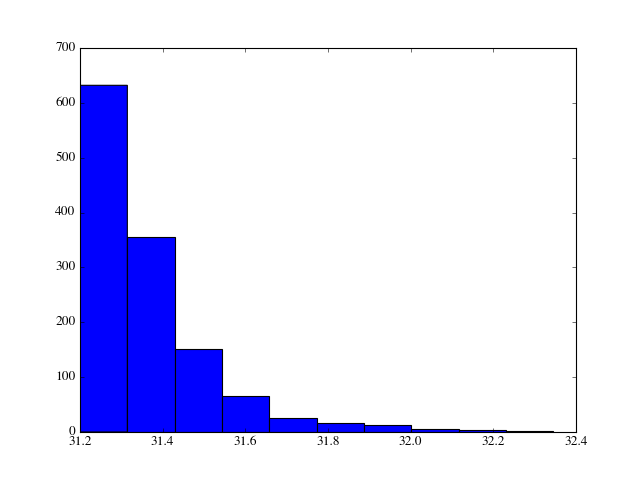

In [39]:
plt.clf()
ax = plt.gca()
ax.hist(final_tpe['FG_LOGLV'])
plt.show()

### R

In [44]:
b_coords = SkyCoord(ra=final_tpe['BG_RA'], dec=final_tpe['BG_DEC'], unit='deg')
f_coords = SkyCoord(ra=final_tpe['FG_RA'], dec=final_tpe['FG_DEC'], unit='deg')
kpc_amin = cosmo.kpc_comoving_per_arcmin(final_tpe['FG_Z'])  # kpc per arcmin
ang_seps = b_coords.separation(f_coords)
rho = ang_seps.to('arcmin') * kpc_amin #/ (1+final_tpe['FG_Z']) # Physical

<IPython.core.display.Javascript object>


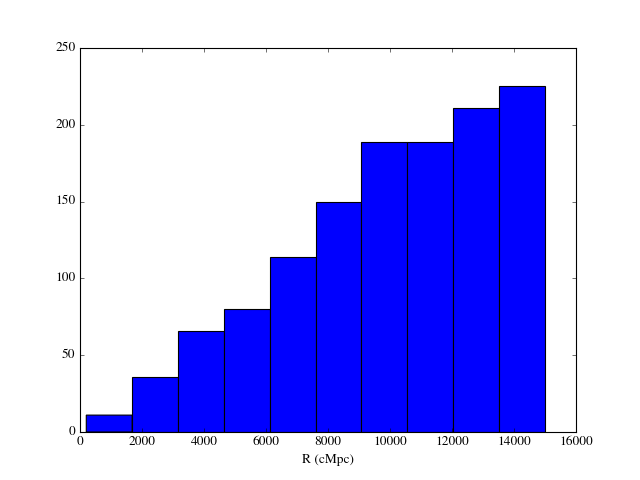

In [47]:
plt.clf()
ax = plt.gca()
ax.hist(rho)
ax.set_xlabel('R (cMpc)')
plt.show()

In [46]:
final_cut = rho < 4*u.Mpc
np.sum(final_cut)

92

In [54]:
final_tpe = final_tpe[final_cut]
final_tpe

FG_Z,FG_LOGLV,FG_RA,FG_DEC,FG_IGM_ID,FG_QPQ_ID,FG_MYERS_ZEM_SOURCE,BG_Z,BG_RA,BG_DEC,BG_IGM_ID,BG_QPQ_ID
float64,float64,float64,float64,int64,int64,str8,float64,float64,float64,int64,int64
2.56533193588,31.2072233915,238.7767,36.898933,250149,-1,SDSS-HW,2.99117398262,238.74877,36.870192,250115,-1
2.65300011635,31.2413673566,246.58704,28.490181,258670,-1,BOSS_PCA,2.70000004768,246.55975,28.468229,258652,737
2.65300011635,31.2413673566,246.58704,28.490181,258670,-1,BOSS_PCA,2.96233797073,246.58469,28.471664,258668,738
2.34824705124,31.3059210224,22.5515041351,15.5328006744,23483,-1,SDSS-HW,2.67803168297,22.558516,15.566373,23492,-1
2.55693411827,31.2022110041,132.504,28.600601,65497,-1,SDSS-HW,2.64122366905,132.47628,28.577134,65450,-1
2.49014496803,31.2104510429,248.73399,30.24383,260445,2884,SDSS-HW,2.93283104897,248.75028,30.222702,260462,2422
2.12688207626,31.2144865286,135.00613,8.4979715,319558,-1,SDSS-HW,2.46717715263,135.04364,8.5123848,69995,-1
2.12299990654,31.2121651744,135.00613,8.4979715,319558,-1,VCV,2.46717715263,135.04364,8.5123848,69995,-1
2.47708392143,31.2327545442,140.87186,12.553282,79375,-1,SDSS-HW,2.67425441742,140.89108,12.552382,79414,-1


## Check against old TPE

In [62]:
old_312 = Table.read('TPE_DR12_31.2_spec.fits')

In [63]:
b_coords = SkyCoord(ra=old_312['BG_RA'], dec=old_312['BG_DEC'], unit='deg')
f_coords = SkyCoord(ra=old_312['FG_RA'], dec=old_312['FG_DEC'], unit='deg')
kpc_amin = cosmo.kpc_comoving_per_arcmin(old_312['FG_Z'])  # kpc per arcmin
ang_seps = b_coords.separation(f_coords)
rho = ang_seps.to('arcmin') * kpc_amin

In [65]:
cut_old = rho < 4*u.Mpc
cut_312 = old_312[cut_old]
cut_312

FG_Z,FG_LOGLV,FG_G_UV,FG_RA,FG_DEC,BG_Z,BG_RA,BG_DEC,BG_LYA_INSTRUMENT,BG_LYA_FILE
float64,float32,float64,float64,float64,float64,float64,float64,str8,str39
2.4849998951,31.5575,1115.08614949,17.9586150746,14.0281577616,2.93550395966,17.9558203147,14.0377133359,LRIS,SDSSJ011149.40+140215.8_b1200_F.fits.gz
3.16700005531,31.4852,831.522317098,24.1232678295,15.0480795383,3.38800001144,24.1307876106,15.0384509056,LRIS,SDSSJ013631.39+150218.4_b400_F.fits.gz
2.12019991875,31.4614,402.793233588,175.480992282,53.2188131441,2.21753907204,175.487077905,53.232746766,LRIS,SDSSJ114156.88+531358.1_b1200_F.fits.gz
3.23960494995,31.3928,128.520587899,184.833240694,20.8201374387,3.30232191086,184.861217872,20.8100352711,BOSS,SDSSJ121926.69+204836.1.fits
2.40697693825,31.4277,70.3259723466,194.892884755,7.86686178365,2.73218297958,194.863196393,7.88347779013,BOSS,SDSSJ125927.17+075300.5.fits
1.73456704617,31.3287,2145.93843303,221.122497067,31.2225650079,1.79499995708,221.11651431,31.2205412644,LRIS,SDSSJ144427.97+311313.8_b1200_F.fits.gz
2.56533193588,31.2218,39.2516575125,238.776705163,36.8989334706,2.99117398262,238.748773913,36.8701924469,BOSS,SDSSJ155459.70+365212.7.fits
2.49014496803,31.2254,79.5163590278,248.733981074,30.2438399897,2.93283104897,248.750273771,30.2227065829,ESI,SDSSJ163500.06+301321.7_F.fits.gz
2.25060009956,31.2726,36.0255833933,333.071995474,0.540825220745,2.46805906296,333.110047127,0.548692504361,BOSS,SDSSJ221226.41+003255.3.fits


In [66]:
old_coord = SkyCoord(ra=cut_312['FG_RA'], dec=cut_312['FG_DEC'], unit='deg')
new_coord = SkyCoord(ra=final_tpe['FG_RA'], dec=final_tpe['FG_DEC'], unit='deg')

In [67]:
idx, d2d, d3d = match_coordinates_sky(old_coord, new_coord, nthneighbor=1)
no_match = d2d > 2*u.arcsec
np.sum(no_match)

0